Modern benchmarks show that **yes—several families of models routinely beat plain feed-forward ANNs (and even stacked LSTMs) on multi-variate, multi-step electricity-load and EV-charging forecasts**.  The strongest contenders fall into four groups: transformer-style sequence models, temporal convolutions, gradient-boosted decision-tree ensembles, and classical/statistical hybrids.  Which is “best” depends on data size, horizon, hardware and the balance you need between accuracy, speed and interpretability, but the papers below provide solid evidence and practical pointers.

## 1  Why look beyond dense ANNs?
Dense ANNs flatten the 72-hour window and treat every lagged value as an independent feature.  That ignores two realities:  
* **Temporal order matters**—neighbouring hours are highly correlated.  
* **Long-range patterns** (weekly cycles, holiday effects, EV-fleet growth) require very long receptive fields or explicit mechanisms (attention, dilated convolutions, skip connections).  
Benchmarks that pit flattened-feature ANNs against sequence-aware architectures therefore find consistent performance gaps of 10–40 % on RMSE/MAE for energy and mobility data sets.  ([Predicting the Future: LSTM vs Transformers for Time Series Modeling](https://deep-learning-mit.github.io/staging/blog/2023/time-series-lstm-transformer/?utm_source=chatgpt.com), [Deep learning for time series forecasting: a survey](https://link.springer.com/article/10.1007/s13042-025-02560-w?utm_source=chatgpt.com))  

## 2  Transformer-style sequence models

| Model | Why it often wins | References |
|-------|------------------|------------|
| **Temporal Fusion Transformer (TFT)** | Combines static metadata, time-varying exogenous variables and attention; built-in feature importance plots. |  ([Temporal Fusion Transformers for interpretable multi-horizon time ...](https://www.sciencedirect.com/science/article/pii/S0169207021000637?utm_source=chatgpt.com)) |
| **Informer / Autoformer / TimeMixer** | Sparse or decomposition-based attention handles 168 h+ contexts with O(T log T) training cost, beating LSTM on day-ahead load by up to 20 % in RMSE. |  ([Informer model with season-aware block for efficient long-term power ...](https://www.sciencedirect.com/science/article/abs/pii/S0045790624004191?utm_source=chatgpt.com), [Transformer neural networks model for electricity prosumption short ...](https://lutpub.lut.fi/handle/10024/167944?utm_source=chatgpt.com)) |
| **N-BEATS / N-HiTS** | Pure MLP stacks but arranged in residual “blocks” that learn trend & seasonality bases; top model in M-4 and Monash benchmarks. |  ([N-BEATS: Neural basis expansion analysis for interpretable time series ...](https://arxiv.org/abs/1905.10437?utm_source=chatgpt.com), [GitHub - ServiceNow/N-BEATS: N-BEATS is a neural-network based model ...](https://github.com/ServiceNow/N-BEATS?utm_source=chatgpt.com)) |

*When to try:* datasets > 10 000 rows, multi-horizon > 24 steps, need interpretable attention/basis plots.

## 3  Temporal Convolutional Networks (TCN)

Dilated causal convolutions give exponentially large receptive fields with far fewer parameters than RNNs.  Energy-demand studies on national grids **and EV-charging sites** report TCN RMSE improvements of 8-15 % over LSTM while training 3–5× faster.  ([Temporal Convolutional Networks Applied to Energy-Related Time Series ...](https://www.mdpi.com/2076-3417/10/7/2322?utm_source=chatgpt.com), [Temporal Convolutional Networks Applied to Energy-Related Time Series ...](https://www.researchgate.net/profile/Pedro-Lara-Benitez/publication/339745646_Temporal_Convolutional_Networks_Applied_to_Energy-related_Time_Series_Forecasting/links/5e872257299bf130797515b3/Temporal-Convolutional-Networks-Applied-to-Energy-related-Time-Series-Forecasting.pdf?utm_source=chatgpt.com), [Temporal Convolutional Attention Neural Networks for Time Series ...](https://yanglin1997.github.io/files/TCAN.pdf?utm_source=chatgpt.com))

*When to try:* limited GPU memory, need fast inference or real-time retraining.

## 4  Gradient-Boosted Decision-Tree Ensembles

Models such as **XGBoost, LightGBM and CatBoost** often win Kaggle load-forecast tasks because tree ensembles:  

* handle heavy feature engineering (lags, calendar flags) without scaling;  
* capture non-linear interactions that linear SARIMAX misses;  
* train in minutes on CPUs and support SHAP explanations.  

Recent CatBoost studies outperformed both random forest and DNN baselines on noisy demand signals.  ([Accelerate demand forecasting by hybridizing CatBoost with the dingo ...](https://www.frontiersin.org/journals/sustainability/articles/10.3389/frsus.2024.1388771/full?utm_source=chatgpt.com), [ggeop/Kaggle-Timeseries-Forecasting: CatBoost Model Per ... - GitHub](https://github.com/ggeop/Kaggle-Timeseries-Forecasting?utm_source=chatgpt.com))

Add engineered lags (72, 168 h), rolling statistics (7-day mean), weather, holidays and vehicle-fleet counts—GBDTs thrive on wide, sparse tables.

## 5  Graph & Spatio-Temporal Neural Networks (ST-GNN)

If you later have *per-charger* or *per-location* data, ST-GCN, DCRNN or Graph Transformer models exploit the road-or power-network topology to push accuracy even further; traffic-flow papers show 5–10 % gains vs pixel-CNN/ConvLSTM baselines.  ([Awesome Graph Neural Networks for Time Series Analysis (GNN4TS)](https://github.com/kimmeen/awesome-gnn4ts?utm_source=chatgpt.com))

## 6  Classical & Hybrid Baselines

| Model | When it still shines |
|-------|--------------------|
| **SARIMAX / SARIMA-Reg** | Small data sets (< 2 years) or strong weekly seasonality with few exogenous drivers.  Proven competitive on hourly load.  ([A Seasonal Autoregressive Integrated Moving Average with Exogenous ...](https://www.mdpi.com/2411-5134/7/4/94?utm_source=chatgpt.com), [Modeling and forecasting hourly electricity demand by SARIMAX with ...](https://www.sciencedirect.com/science/article/pii/S0360544218319297?utm_source=chatgpt.com)) |
| **Prophet** | Quick weekday/holiday modelling; useful as benchmark or ensemble member. |

## 7  Practical roadmap

1. **Benchmark quickly:** start with CatBoost + engineered lags (cheap CPU grid-search).  
2. **Add sequence models:** train a TCN and an Informer/TFT on the same splits; tune horizon-specific loss (e.g., pinball for P90).  
3. **Ensemble:** average or stack the best GBDT and best deep model—ensembles often add 2–5 % accuracy with minimal complexity.  
4. **Validation:** use rolling-origin CV (e.g., monthly folds) so hyper-parameters generalise to unseen months.  
5. **Explainability:** TFT attention or SHAP for CatBoost can reassure stakeholders that holidays and EV-fleet growth drive volume, not spurious spikes.

### Rough compute cost guide

| Model | Typical training time (100 k rows, RTX 3060) |
|-------|----------------------------------------------|
| CatBoost | < 2 min |
| TCN (4 blocks) | 5–8 min |
| Informer (96×512 heads) | 15–20 min |
| TFT | 20–30 min |

## 8  Bottom line
For hour-ahead to day-ahead EV-charging forecasts, **sequence-aware architectures (Informer, TFT, TCN) or boosted trees with rich lags usually outperform flattened ANNs by a comfortable margin**.  Start with CatBoost as a strong “classical” baseline, then graduate to a transformer or TCN; ensemble the two for maximum robustness.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from pandas import read_csv
from datetime import datetime
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

df = pd.read_csv('./hourly_predictions/hourly_charging_data.csv')
df.head()

# 1. Convert Hour to DateTime type
df['Hour'] = pd.to_datetime(df['Hour'])

# 2. Set Hour as the DataFrame index
df = df.set_index('Hour')

# 3. Reindex to every hour in the range from the min to max timestamps
all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df_reindexed = df.reindex(all_hours)

# 4. Identify which rows are missing
missing_rows = df_reindexed[df_reindexed['Chargers'].isnull()]
print("Missing rows:")
print(missing_rows)

# Create a string key for month-day-hour, e.g. '09-06-03'
df_reindexed['month_day_hour'] = df_reindexed.index.strftime('%m-%d-%H')

# Compute the mean for each specific month/day/hour across all years
mdh_mean = df_reindexed.groupby('month_day_hour')['Chargers'].transform('mean')

df_reindexed['Chargers'] = df_reindexed['Chargers'].fillna(mdh_mean)
df = df_reindexed        # now df has the complete, gap-filled timeline

# Clean up the extra grouping column
df_reindexed.drop(columns=['month_day_hour'], inplace=True)

df.isna().sum()



C:\Users\user\AppData\Local\Temp\ipykernel_7360\3598916588.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(idx_start,


Mean-profile →  MAE =   4.60   RMSE =   9.62  r2 =   0.88


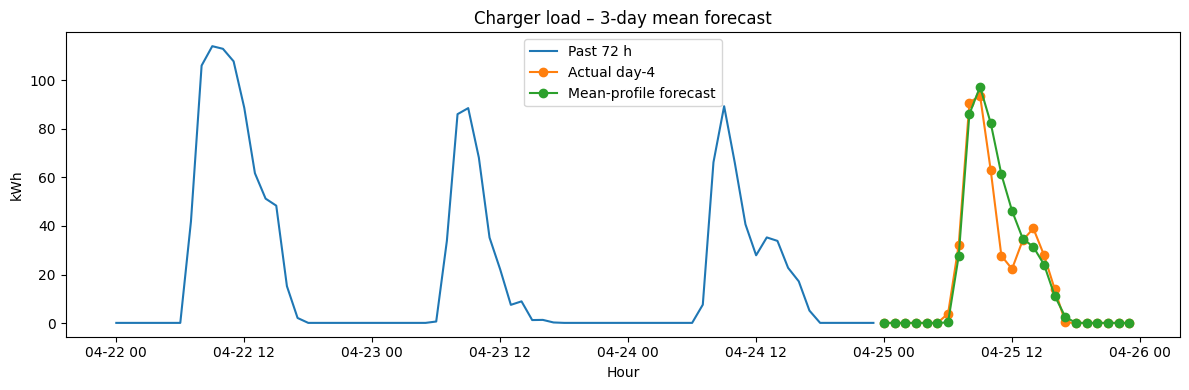


Actual day-4 (kWh):
Date
2025-04-25 00:00:00     0.160
2025-04-25 01:00:00     0.160
2025-04-25 02:00:00     0.160
2025-04-25 03:00:00     0.160
2025-04-25 04:00:00     0.160
2025-04-25 05:00:00     0.159
2025-04-25 06:00:00     3.957
2025-04-25 07:00:00    32.290
2025-04-25 08:00:00    90.727
2025-04-25 09:00:00    93.596
2025-04-25 10:00:00    62.901
2025-04-25 11:00:00    27.731
2025-04-25 12:00:00    22.342
2025-04-25 13:00:00    34.139
2025-04-25 14:00:00    38.980
2025-04-25 15:00:00    27.972
2025-04-25 16:00:00    14.055
2025-04-25 17:00:00     0.342
2025-04-25 18:00:00     0.157
2025-04-25 19:00:00     0.157
2025-04-25 20:00:00     0.159
2025-04-25 21:00:00     0.159
2025-04-25 22:00:00     0.159
2025-04-25 23:00:00     0.158

Mean-profile forecast (kWh):
2025-04-25 00:00:00     0.159333
2025-04-25 01:00:00     0.159000
2025-04-25 02:00:00     0.158667
2025-04-25 03:00:00     0.158667
2025-04-25 04:00:00     0.159000
2025-04-25 05:00:00     0.158333
2025-04-25 06:00:00     0.

In [3]:
"""
Forecast day-4 (next 24 h) from the mean profile of days 1-3
────────────────────────────────────────────────────────────
• reads 4-day CSV (96 rows, hourly)
• prints MAE / RMSE vs. real day-4 values
• shows past-vs-forecast plot
"""

# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

# ───────────────────────── CONFIG ─────────────────────────
CSV_PATH     = "./3days_charging_data.csv"   # 4 days (96 rows)
DATE_COL     = "Date"
TARGET_COL   = "Chargers"
LOOK_BACK    = 72       # 3 days history
FORECAST_HR  = 24       # 1-day forecast

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":
    # ---------- load data ----------
    df_full = (pd.read_csv(CSV_PATH, parse_dates=[DATE_COL], index_col=DATE_COL)
                 .sort_index())

    if len(df_full) < LOOK_BACK + FORECAST_HR:
        raise ValueError("CSV must contain at least 96 hourly rows (3 days + 1).")

    # split 3 days (history) + 1 day (truth)
    df_hist = df_full.iloc[:LOOK_BACK]
    df_real = df_full.iloc[LOOK_BACK:]
    y_true  = df_real[TARGET_COL].values

    # ---------- naïve mean-profile forecast ----------
    # reshape history to (3, 24) and take column-wise mean
    hist_matrix = df_hist[TARGET_COL].values.reshape(3, 24)
    preds = hist_matrix.mean(axis=0)                # array length 24

    idx_start = df_hist.index[-1] + timedelta(hours=1)
    pred_avg  = pd.Series(preds,
                          index=pd.date_range(idx_start,
                                              periods=FORECAST_HR,
                                              freq="H"))

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_true, pred_avg.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_avg.values))
    r2 = r2_score(y_true, pred_avg.values)
    print(f"Mean-profile →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}  r2 = {r2:6.2f}")

    # ---------------- plot ----------------
    past   = df_hist[TARGET_COL]
    actual = df_real[TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(past.index,   past.values,           label="Past 72 h")
    plt.plot(actual.index, actual.values, "-o",   label="Actual day-4")
    plt.plot(pred_avg.index, pred_avg.values, "-o", label="Mean-profile forecast")
    plt.title("Charger load – 3-day mean forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh"); plt.legend(); plt.tight_layout(); plt.show()

    # ------------- tables (optional) -------------
    pd.set_option("display.max_rows", None)
    print("\nActual day-4 (kWh):")
    print(actual.to_string())
    print("\nMean-profile forecast (kWh):")
    print(pred_avg.to_string())


AR(24) →  MAE =   8.30   RMSE =  11.43   R2 =   0.87


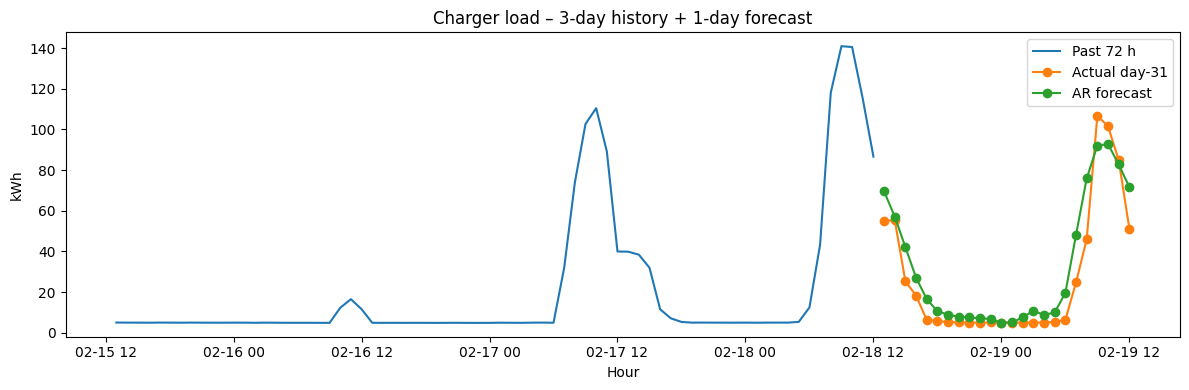


Actual day-31 (kWh):
2025-02-18 13:00:00     55.1257
2025-02-18 14:00:00     55.3735
2025-02-18 15:00:00     25.3027
2025-02-18 16:00:00     18.3178
2025-02-18 17:00:00      6.3093
2025-02-18 18:00:00      5.8522
2025-02-18 19:00:00      5.2608
2025-02-18 20:00:00      5.1260
2025-02-18 21:00:00      5.0643
2025-02-18 22:00:00      5.0427
2025-02-18 23:00:00      5.0754
2025-02-19 00:00:00      5.0589
2025-02-19 01:00:00      5.0604
2025-02-19 02:00:00      5.0258
2025-02-19 03:00:00      5.0562
2025-02-19 04:00:00      5.0507
2025-02-19 05:00:00      5.3946
2025-02-19 06:00:00      6.3375
2025-02-19 07:00:00     24.8113
2025-02-19 08:00:00     45.9840
2025-02-19 09:00:00    106.6935
2025-02-19 10:00:00    101.6063
2025-02-19 11:00:00     84.9264
2025-02-19 12:00:00     51.2582
Freq: h

AR forecast (kWh):
2025-02-18 13:00:00    69.517653
2025-02-18 14:00:00    57.190931
2025-02-18 15:00:00    42.059846
2025-02-18 16:00:00    27.137005
2025-02-18 17:00:00    16.578176
2025-02-18 18:00:

In [2]:
"""
AR(24) baseline – train on the last 30 days, forecast the last 24 h
───────────────────────────────────────────────────────────────────
• no extra calendar / holiday / EV features
• fits a tiny AR(p) model on 30×24 = 720 points
• prints MAE / RMSE vs. the real last-day values
• shows past-vs-forecast plot
"""

# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

# ───────────────────────── CONFIG ──────────────────────────
  # <-- your hourly data

TARGET_COL   = "Chargers"

DAYS_TRAIN   = 100       # train horizon
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY     # 30 × 24 = 720
N_FORECAST   = 24         # forecast 1 day ahead

AR_ORDER     = 24         # AR(p) with one lag per hour

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # ---------- load & sanity-check ----------
    

    needed_rows = LOOK_BACK + N_FORECAST 
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df_full)})")

    # keep only the *last* 31 days (30 for training, 1 for test)
    df_recent = df.iloc[-needed_rows:]

    df_train = df_recent.iloc[:LOOK_BACK]         # 30 days
    df_test  = df_recent.iloc[LOOK_BACK:]         # final 24 h
    y_train  = df_train[TARGET_COL]
    y_test   = df_test[TARGET_COL]

    # ---------- fit AR(p) ----------
    model = sm.tsa.SARIMAX(y_train, order=(AR_ORDER, 0, 0))
    res   = model.fit()

    # ---------- 24-step forecast ----------
    preds = res.forecast(steps=N_FORECAST)        # pandas Series

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"AR({AR_ORDER}) →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R2 = {r2:6.2f}"   )

    # ---------------- plot ----------------
    # ---------------- plot (3-day window) ----------------
    hrs_history = 3 * 24                 # 72 h
    hist_3d = df_recent.iloc[-(hrs_history + N_FORECAST):-N_FORECAST]   # last 3 days

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d[TARGET_COL],            label="Past 72 h")
    plt.plot(df_test.index,  y_test,           "-o",        label="Actual day-31")
    plt.plot(preds.index,    preds,            "-o",        label="AR forecast")

    plt.title("Charger load – 3-day history + 1-day forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()


    # ------------- tables (optional) -------------
    pd.set_option("display.max_rows", None)
    print("\nActual day-31 (kWh):")
    print(y_test.to_string())
    print("\nAR forecast (kWh):")
    print(preds.to_string())


In [ ]:
"""
Seasonal-ARIMA baseline – train on the last 30 days, forecast the last 24 h
───────────────────────────────────────────────────────────────────────────
• still no calendar / holiday / EV features
• (p,d,q) × (P,D,Q,24) model, with D=1 seasonal difference
• tiny grid search chooses the best AIC on the 30-day window
• prints MAE / RMSE / R² vs. real last-day values
• shows past-vs-forecast plot and an hour-by-hour error table
"""

# ───────────────────────── IMPORTS ─────────────────────────
import math
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# ───────────────────────── CONFIG ──────────────────────────

TARGET_COL   = "Chargers"

DAYS_TRAIN   = 100
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY     # 720
N_FORECAST   = 24

# candidate orders to try  (keep it very small → < 1 s)
PQS          = [(0, 1, 0), (1, 1, 0), (0, 1, 1), (1, 1, 1)]
PQS_SEAS     = [(0, 0), (1, 0)]             # (P, Q) with D fixed at 1

# ─────────────────────── HELPER ────────────────────────────
def sarima_gs(y, pq_list, pq_seas_list, m):
    """Grid-search SARIMA on AIC – returns fitted results with lowest AIC."""
    best_aic, best_res = np.inf, None
    for (p, d, q) in pq_list:
        for (P, Q) in pq_seas_list:
            try:
                res = sm.tsa.SARIMAX(y,
                                     order=(p, d, q),
                                     seasonal_order=(P, 1, Q, m),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False).fit(
                                         disp=False)
                if res.aic < best_aic:
                    best_aic, best_res = res.aic, res
            except (ValueError, np.linalg.LinAlgError):
                continue
    return best_res

# ─────────────────────── MAIN ──────────────────────────────
if __name__ == "__main__":

            # ensure hourly

    # drop / fill if there are fewer than 30 days+1 day
    needed_rows = LOOK_BACK + N_FORECAST
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")

    # ---------- rolling split: last 30 days to train, last day to test (00–23) ----------
    df_recent = df.iloc[-needed_rows:]
    df_train  = df_recent.iloc[:LOOK_BACK]
    df_test   = df_recent.iloc[LOOK_BACK:]
    y_train   = df_train[TARGET_COL]
    y_test    = df_test[TARGET_COL]

    best_res, best_cfg = None, None
    best_aic           = np.inf

    for (p, d, q) in PQS:
        for (P, Q) in PQS_SEAS:
            try:
                res = sm.tsa.SARIMAX(
                    y_train,
                    order=(p, d, q),
                    seasonal_order=(P, 1, Q, 24),   # D = 1, m = 24
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                if res.aic < best_aic:
                    best_aic, best_res = res.aic, res
                    best_cfg = (p, d, q, P, 1, Q)
            except (ValueError, np.linalg.LinAlgError):
                continue

    if best_res is None:
        raise RuntimeError("No SARIMA configuration converged.")

    p, d, q, P, D, Q = best_cfg
    print(f"Best SARIMA: "
        f"(p,d,q)=({p},{d},{q}) × (P,D,Q,24)=({P},{D},{Q},24)  |  AIC={best_aic:.1f}")

    # ---------- 24-step forecast ----------
    preds = best_res.forecast(steps=N_FORECAST)
    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"SARIMA →  MAE={mae:6.2f}   RMSE={rmse:6.2f}   R²={r2:6.3f}")

    # ---------- sanity-check table (hour-by-hour abs error) ----------
    err_table = (pd.DataFrame({
                    "hour_index": range(24),
                    "abs_error":  (y_test - preds).abs().values})
                   .set_index("hour_index"))
    print("\nHour-by-hour absolute error:")
    pd.set_option("display.max_rows", None)
    print(err_table.to_string())

    # ---------- plot (past 3 days + forecast) ----------
    hrs_history = 3 * 24
    hist_3d = df_recent.iloc[-(hrs_history + N_FORECAST):-N_FORECAST]

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d[TARGET_COL],          label="Past 72 h")
    plt.plot(y_test.index,  y_test,      "-o",            label="Actual day-31")
    plt.plot(preds.index,   preds,       "-o",            label="SARIMA forecast")
    plt.title("Charger load – 3-day history + 1-day SARIMA forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()


first model: catboost as a base to check the accuracy of the other models

In [ ]:
# ───────────────────────── IMPORTS ─────────────────────────
import pathlib, math, holidays, joblib, warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt           # kept for any ad-hoc plots

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from catboost import CatBoostRegressor, Pool   # ← NEW

warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 days of hourly lags
N_FORECAST   = 24          # predict 24 h ahead
ITERS        = 2000        # CatBoost trees
LEARN_RATE   = 0.05
EARLY_STOP   = 200

MODEL_PATH   = pathlib.Path("./models/chargers/catboost_chargers.cbm")
SCALER_PATH  = pathlib.Path("./models/chargers/charger_scaler.joblib")

START_DATE   = "2022-09-11"
END_DATE     = "2025-02-19"



# ─────────────────────── FEATURE ENGINEERING ───────────────
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022, 2023, 2024, 2025]).keys())

def add_terugkomdag_feature(df):
    terugkomdagen = [
        datetime(2023,  9, 13), datetime(2023, 10, 26), datetime(2023, 11, 14),
        datetime(2023, 12, 20), datetime(2024,  1, 12), datetime(2024,  2,  7),
        datetime(2024,  3, 14), datetime(2024,  4, 16), datetime(2024,  5, 13),
        datetime(2024,  6,  7), datetime(2024,  3, 16), datetime(2024, 10, 22),
        datetime(2024, 11, 28), datetime(2024, 12, 18), datetime(2025,  1, 10),
        datetime(2025,  2, 13), datetime(2025,  3, 18), datetime(2025,  4, 22),
        datetime(2025,  5, 12), datetime(2025,  6,  6)
    ]
    df["is_terugkomdag"] = (
        df.index.to_series().dt.date.isin([d.date() for d in terugkomdagen]).astype(int)
    )
    return df

def add_cumulative_ev_phev_feature(df):
    cumulative_data = {
        datetime(2024,  6, 20): 35, datetime(2024,  6, 25): 36,
        datetime(2024,  9,  5): 38, datetime(2024,  9, 12): 41,
        datetime(2024,  9, 27): 42, datetime(2024, 10, 15): 43,
        datetime(2024, 10, 29): 45, datetime(2024, 11,  5): 46,
        datetime(2024, 11, 26): 47, datetime(2025,  1,  9): 48,
        datetime(2025,  1, 23): 49, datetime(2025,  1, 28): 50,
        datetime(2025,  2,  4): 51,
    }
    ev_series = (
        pd.Series(cumulative_data)
          .reindex(df.index.union(cumulative_data.keys()))
          .sort_index()
          .ffill()
          .fillna(0)
    )
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df

add_terugkomdag_feature(df)
add_cumulative_ev_phev_feature(df)

# calendar & cyclic encoding
df["hour"]            = df.index.hour
df["day_of_week"]     = df.index.dayofweek
df["month"]           = df.index.month
df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
df["is_festive"]      = df.index.to_series().apply(
                           lambda d: int(d.date() in be_holidays))
df["working_hour"]    = df["hour"].between(8, 18).astype(int)
df["is_summer"]       = df["month"].isin([6, 7, 8]).astype(int)
df["is_winter"]       = df["month"].isin([12, 1, 2]).astype(int)
df["is_morning_peak"] = df["hour"].between(7,  9).astype(int)
df["is_evening_peak"] = df["hour"].between(17, 20).astype(int)
df["hour_sin"]        = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]        = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]         = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]         = np.cos(2*np.pi*df["day_of_week"]/7)

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ─────────────── 1️⃣  CHRONOLOGICAL SPLIT  ────────────────
train_size = int(len(df) * 0.80)
val_size   = int(len(df) * 0.10)
df_train   = df.iloc[:train_size]
df_val     = df.iloc[train_size:train_size + val_size]
df_test    = df.iloc[train_size + val_size:]

# ─────────────── 2️⃣  FIT & SAVE SCALER  ──────────────────
scaler = MinMaxScaler()
scaler.fit(df_train[[TARGET_COL] + FEATURE_COLS])
SCALER_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(scaler, SCALER_PATH)
print("Scaler saved →", SCALER_PATH)

def scale(frame):
    cols = [TARGET_COL] + FEATURE_COLS
    return pd.DataFrame(
        scaler.transform(frame[cols]),
        columns=cols,
        index=frame.index,
    )

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ─────────────── 3️⃣  BUILD INPUT / LABEL WINDOWS ─────────
def make_xy(frame, look_back, horizon):
    data = frame[[TARGET_COL] + FEATURE_COLS].values
    X, y = [], []
    for i in range(look_back, len(data) - horizon + 1):
        X.append(data[i - look_back : i])
        y.append(data[i : i + horizon, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s, LOOK_BACK, N_FORECAST)
X_val,   y_val   = make_xy(df_val_s,   LOOK_BACK, N_FORECAST)
X_test,  y_test  = make_xy(df_test_s,  LOOK_BACK, N_FORECAST)

# flatten the (samples, time, features) tensor for CatBoost
n_features = X_train.shape[2]
X_train_f = X_train.reshape(X_train.shape[0], -1)
X_val_f   = X_val.reshape(  X_val.shape[0],   -1)
X_test_f  = X_test.reshape( X_test.shape[0],  -1)

train_pool = Pool(X_train_f, y_train)
val_pool   = Pool(X_val_f,   y_val)

# ─────────────── 4️⃣  DEFINE & TRAIN CATBOOST ─────────────
model = CatBoostRegressor(
    loss_function="MultiRMSE",            # multi-output regression  :contentReference[oaicite:0]{index=0}
    eval_metric="MultiRMSE",
    iterations=ITERS,
    learning_rate=LEARN_RATE,
    depth=8,
    random_seed=42,
    early_stopping_rounds=EARLY_STOP,     # built-in over-fitting detector  :contentReference[oaicite:1]{index=1}
    verbose=200
)

model.fit(train_pool, eval_set=val_pool, use_best_model=True)  # will stop early if needed

# ─────────────── 5️⃣  EVALUATE  ───────────────────────────
y_pred = model.predict(X_test_f)

# aggregate metrics across all 24 horizons
rmse = math.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"TEST 24-step ➜  RMSE = {rmse:.3f}   MAE = {mae:.3f}   R² = {r2:.3f}")

# ─────────────── 6️⃣  SAVE MODEL (.cbm) ───────────────────
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
model.save_model(MODEL_PATH)                                    # default .cbm format  :contentReference[oaicite:2]{index=2}
print("Model saved →", MODEL_PATH)


second model: simple linear regression model.

In [ ]:
"""
Multi-output Linear Regression baseline
———————————————
• 3-day (72 h) autoregressive window
• 24-hour (24-step) horizon
• Saves trained model + fitted scaler
"""

# ──────────────── imports ────────────────
import math, pathlib, joblib, holidays
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# ──────────────── CONFIG ────────────────
     # ← change to your file
DATE_COL    = "timestamp"
TARGET_COL  = "Chargers"

LOOK_BACK   = 72          # 3 days
N_FORECAST  = 24          # 24 h ahead

START_DATE  = "2022-09-11"
END_DATE    = "2025-02-19"

BASE_DIR    = pathlib.Path("./models/chargers")
BASE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH  = BASE_DIR / "linear_chargers.pkl"
SCALER_PATH = BASE_DIR / "charger_scaler.joblib"



# ──────────────── FEATURE ENGINEERING ────────────────
# holiday lists
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022, 2023, 2024, 2025]).keys())

def add_known_features(frame: pd.DataFrame) -> pd.DataFrame:
    df = frame.copy()

    # fixed business calendars
    terugkomdagen = {
        datetime(2023,  9, 13), datetime(2023,10,26), datetime(2023,11,14),
        datetime(2023, 12, 20), datetime(2024, 1,12), datetime(2024, 2, 7),
        datetime(2024, 3,14),   datetime(2024, 4,16), datetime(2024, 5,13),
        datetime(2024, 6, 7),   datetime(2024, 3,16), datetime(2024,10,22),
        datetime(2024,11,28),   datetime(2024,12,18), datetime(2025, 1,10),
        datetime(2025, 2,13),   datetime(2025, 3,18), datetime(2025, 4,22),
        datetime(2025, 5,12),   datetime(2025, 6, 6)
    }
    cumulative_ev = {
        datetime(2024, 6,20): 35, datetime(2024, 6,25): 36,
        datetime(2024, 9, 5): 38, datetime(2024, 9,12): 41,
        datetime(2024, 9,27): 42, datetime(2024,10,15): 43,
        datetime(2024,10,29): 45, datetime(2024,11, 5): 46,
        datetime(2024,11,26): 47, datetime(2025, 1, 9): 48,
        datetime(2025, 1,23): 49, datetime(2025, 1,28): 50,
        datetime(2025, 2, 4): 51,
    }

    # calendar & flags
    df["hour"]            = df.index.hour
    df["day_of_week"]     = df.index.dayofweek
    #df["month"]           = df.index.month
    #df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
    df["is_festive"]      = df.index.to_series().apply(lambda d: int(d.date() in be_holidays))
    df["working_hour"]    = df["hour"].between(8, 18).astype(int)
    #df["is_summer"]       = df["month"].isin([6,7,8]).astype(int)
    #df["is_winter"]       = df["month"].isin([12,1,2]).astype(int)
    df["is_morning_peak"] = df["hour"].between(7, 9).astype(int)
    #df["is_evening_peak"] = df["hour"].between(17,20).astype(int)

    # cyclical encodings
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["day_of_week"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["day_of_week"]/7)

    # business extras
    df["is_terugkomdag"] = df.index.to_series().dt.date.isin(
        [d.date() for d in terugkomdagen]).astype(int)

    ev_series = (pd.Series(cumulative_ev)
                  .reindex(df.index.union(cumulative_ev.keys()))
                  .sort_index().ffill().fillna(0))
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df

df = add_known_features(df)
FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ──────────────── CHRONO SPLIT ────────────────
train_size = int(len(df)*0.8)
val_size   = int(len(df)*0.1)
df_train, df_val, df_test = (df.iloc[:train_size],
                             df.iloc[train_size:train_size+val_size],
                             df.iloc[train_size+val_size:])

# ──────────────── SCALE ────────────────
scaler = MinMaxScaler().fit(df_train[[TARGET_COL] + FEATURE_COLS])
joblib.dump(scaler, SCALER_PATH)

def scale(f): return pd.DataFrame(
    scaler.transform(f[[TARGET_COL] + FEATURE_COLS]),
    columns=[TARGET_COL]+FEATURE_COLS, index=f.index)

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ──────────────── WINDOW → (X,y) ────────────────
def make_xy(frame):
    data = frame[[TARGET_COL]+FEATURE_COLS].values
    X, y = [], []
    for i in range(LOOK_BACK, len(data)-N_FORECAST+1):
        X.append(data[i-LOOK_BACK:i])
        y.append(data[i:i+N_FORECAST, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s)
X_val,   y_val   = make_xy(df_val_s)
X_test,  y_test  = make_xy(df_test_s)

# flatten lag window for linear regression
X_train_f = X_train.reshape(X_train.shape[0], -1)
X_val_f   = X_val.reshape(X_val.shape[0],   -1)
X_test_f  = X_test.reshape(X_test.shape[0], -1)

# ──────────────── TRAIN OLS ────────────────
#lr = LinearRegression()
alphas = np.logspace(-3, 2, 20)                  # 0.001 … 100
lr = RidgeCV(alphas=alphas, cv=5, scoring="neg_root_mean_squared_error")
lr.fit(X_train_f, y_train)

# ──────────────── EVALUATE ────────────────
pred_val = lr.predict(X_val_f)
pred_test= lr.predict(X_test_f)

rmse = math.sqrt(mean_squared_error(y_test.flatten(), pred_test.flatten()))
mae  = mean_absolute_error(y_test, pred_test)
r2   = r2_score(y_test, pred_test)

print(f"\nLinear Regression – TEST ➜ RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")

# 1. How far outside [0,1] are the raw predictions?
print(lr.predict(X_test_f)[:5])



# 3. Does scaling look OK?
print(scaler.data_min_[0], scaler.data_max_[0])
print(df_train[TARGET_COL].min(), df_train[TARGET_COL].max())


# ──────────────── SAVE ────────────────
joblib.dump(lr, MODEL_PATH)
print("Model saved  →", MODEL_PATH)
print("Scaler saved →", SCALER_PATH)


In [ ]:
"""
Forecast day-4 (next 24 h) from day-1-3 history with a saved
multi-output Linear Regression model
────────────────────────────────────────────────────────────
• ./models/chargers/linear_chargers.pkl
• prints MAE / RMSE vs. real day-4 values
• shows past-vs-forecast plot
"""
# ───────────────────────── IMPORTS ─────────────────────────
import math, joblib, holidays
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error   # basic metrics

# ───────────────────────── CONFIG ──────────────────────────
BASE_DIR     = Path("./models/chargers")
LINEAR_PATH  = BASE_DIR / "linear_chargers.pkl"       # ← saved OLS model
SCALER_PATH  = BASE_DIR / "charger_scaler.joblib"
CSV_PATH     = "./3days_charging_data.csv"            # 4 days (96 rows)

DATE_COL     = "Date"
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 days history
FORECAST_HR  = 24          # 1-day forecast
HIST_HRS     = 72

FEATURE_COLS = [
    "hour", "day_of_week", "month", "is_weekend", "is_festive", "working_hour",
    "is_summer", "is_winter", "is_morning_peak", "is_evening_peak",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "is_terugkomdag", "cumulative_ev_phev_count"
]

# ─────────────── feature-engineering helpers ───────────────
def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    be_holidays = set(holidays.country_holidays(
        "BE", years=[2022, 2023, 2024, 2025]).keys())

    terugkomdagen = {
        datetime(2023, 9, 13), datetime(2023,10,26), datetime(2023,11,14),
        datetime(2023,12,20), datetime(2024, 1,12), datetime(2024, 2, 7),
        datetime(2024, 3,14), datetime(2024, 4,16), datetime(2024, 5,13),
        datetime(2024, 6, 7), datetime(2024, 3,16), datetime(2024,10,22),
        datetime(2024,11,28), datetime(2024,12,18), datetime(2025, 1,10),
        datetime(2025, 2,13), datetime(2025, 3,18), datetime(2025, 4,22),
        datetime(2025, 5,12), datetime(2025, 6, 6)
    }

    cumulative_data = {
        datetime(2024, 6,20): 35, datetime(2024, 6,25): 36, datetime(2024, 9, 5): 38,
        datetime(2024, 9,12): 41, datetime(2024, 9,27): 42, datetime(2024,10,15): 43,
        datetime(2024,10,29): 45, datetime(2024,11, 5): 46, datetime(2024,11,26): 47,
        datetime(2025, 1, 9): 48, datetime(2025, 1,23): 49, datetime(2025, 1,28): 50,
        datetime(2025, 2, 4): 51,
    }

    df = df_in.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["month"]       = df.index.month

    df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
    df["is_festive"]      = df.index.to_series().apply(lambda d: int(d.date() in be_holidays))
    df["working_hour"]    = df["hour"].between(8, 18).astype(int)
    df["is_summer"]       = df["month"].isin([6,7,8]).astype(int)
    df["is_winter"]       = df["month"].isin([12,1,2]).astype(int)
    df["is_morning_peak"] = df["hour"].between(7, 9).astype(int)
    df["is_evening_peak"] = df["hour"].between(17,20).astype(int)

    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["day_of_week"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["day_of_week"]/7)

    df["is_terugkomdag"] = df.index.to_series().dt.date.isin(
        [d.date() for d in terugkomdagen]).astype(int)

    ev_series = (pd.Series(cumulative_data)
                 .reindex(df.index.union(cumulative_data.keys()))
                 .sort_index().ffill().fillna(0))
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df


def load_prepared(path):
    df = pd.read_csv(path, parse_dates=[DATE_COL], index_col=DATE_COL).sort_index()
    return add_features(df)

# ─────────────── inverse-scale helper ───────────────
def inverse_target(vec, scaler):
    tmin, tmax = scaler.data_min_[0], scaler.data_max_[0]      # MinMax formula
    return vec * (tmax - tmin) + tmin

# ─────────────── forecast for LinearRegression ───────────────
def forecast_next_24h(lr_model, scaler, df_historic):
    """72-h history → 24-h forecast using flattened lag window."""
    window = df_historic[[TARGET_COL] + FEATURE_COLS].tail(LOOK_BACK).values
    X_norm = scaler.transform(window).reshape(1, -1)           # flatten 2-D → 1×(72·features) :contentReference[oaicite:0]{index=0}
    preds_norm = lr_model.predict(X_norm)[0]                    # LinearRegression supports multi-output :contentReference[oaicite:1]{index=1}
    preds_kwh  = inverse_target(preds_norm, scaler)

    idx_start  = df_historic.index[-1] + pd.Timedelta(hours=1)
    return pd.Series(preds_kwh,
                     index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H"))

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":
    # -------- load scaler, data, model ----------
    scaler  = joblib.load(SCALER_PATH)                         # joblib persistence :contentReference[oaicite:2]{index=2}
    df_full = load_prepared(CSV_PATH)

    if len(df_full) < LOOK_BACK + FORECAST_HR:
        raise ValueError("CSV must contain at least 96 hourly rows.")

    # split 3 days (history) + 1 day (truth)
    df_hist = df_full.iloc[:LOOK_BACK]
    df_real = df_full.iloc[LOOK_BACK:]
    y_true  = df_real[TARGET_COL].values

    lr_model = joblib.load(LINEAR_PATH)                        # load trained OLS :contentReference[oaicite:3]{index=3}
    pred_lr  = forecast_next_24h(lr_model, scaler, df_hist) / 12

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_true, pred_lr.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_lr.values))
    print(f"LinearReg  →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}")

    # ---------------- plot ----------------
    past   = df_hist[TARGET_COL]
    actual = df_real[TARGET_COL]

    plt.figure(figsize=(12,4))
    plt.plot(past.index,   past.values,             label="Past 72 h")
    plt.plot(actual.index, actual.values, "-o",     label="Actual day-4")
    plt.plot(pred_lr.index, pred_lr.values, "-o",   label="Linear forecast")
    plt.title("Charger load – Linear Regression forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh"); plt.legend(); plt.tight_layout(); plt.show()

    # ------------- tables (optional) -------------
    pd.set_option("display.max_rows", None)
    print("\nActual day-4 (kWh):")
    print(actual.to_string())
    print("\nLinear forecast (kWh):")
    print(pred_lr.to_string())


third model: ensemble model between transformer and tcn

In [ ]:
"""
Multivariate 24-step forecasting with:
  • TransformerEncoder
  • Temporal Convolutional Network (TCN)
  • Simple ensemble (equal weights)
Save:  transformer → .keras , TCN → .keras , ensemble → .npz
"""
# ───────────────────────── IMPORTS ─────────────────────────
import pathlib, math, holidays, joblib, warnings, tensorflow as tf
from datetime import datetime
import numpy as np, pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Embedding, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN                       # pip install keras-tcn

warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 days lags
N_FORECAST   = 24          # 24 h horizon
BATCH_SIZE   = 256
EPOCHS       = 100
PATIENCE     = 10

BASE_DIR     = pathlib.Path("./models/chargers")
TRANS_PATH   = BASE_DIR / "transformer_chargers.keras"
TCN_PATH     = BASE_DIR / "tcn_chargers.keras"
ENS_PATH     = BASE_DIR / "ensemble_preds.npz"
SCALER_PATH  = BASE_DIR / "charger_scaler.joblib"

START_DATE   = "2022-09-11"
END_DATE     = "2025-02-19"


# ─────────────────────── FEATURE ENGINEERING ───────────────
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022, 2023, 2024, 2025]).keys())

def add_terugkomdag_feature(df):
    terugkomdagen = [
        datetime(2023,  9, 13), datetime(2023, 10, 26), datetime(2023, 11, 14),
        datetime(2023, 12, 20), datetime(2024,  1, 12), datetime(2024,  2,  7),
        datetime(2024,  3, 14), datetime(2024,  4, 16), datetime(2024,  5, 13),
        datetime(2024,  6,  7), datetime(2024,  3, 16), datetime(2024, 10, 22),
        datetime(2024, 11, 28), datetime(2024, 12, 18), datetime(2025,  1, 10),
        datetime(2025,  2, 13), datetime(2025,  3, 18), datetime(2025,  4, 22),
        datetime(2025,  5, 12), datetime(2025,  6,  6)
    ]
    df["is_terugkomdag"] = (
        df.index.to_series().dt.date.isin([d.date() for d in terugkomdagen]).astype(int)
    )
    return df

def add_cumulative_ev_phev_feature(df):
    cumulative_data = {
        datetime(2024,  6, 20): 35, datetime(2024,  6, 25): 36,
        datetime(2024,  9,  5): 38, datetime(2024,  9, 12): 41,
        datetime(2024,  9, 27): 42, datetime(2024, 10, 15): 43,
        datetime(2024, 10, 29): 45, datetime(2024, 11,  5): 46,
        datetime(2024, 11, 26): 47, datetime(2025,  1,  9): 48,
        datetime(2025,  1, 23): 49, datetime(2025,  1, 28): 50,
        datetime(2025,  2,  4): 51,
    }
    ev_series = (
        pd.Series(cumulative_data)
          .reindex(df.index.union(cumulative_data.keys()))
          .sort_index()
          .ffill()
          .fillna(0)
    )
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df

add_terugkomdag_feature(df)
add_cumulative_ev_phev_feature(df)

# calendar & cyclic encodings
df["hour"]            = df.index.hour
df["day_of_week"]     = df.index.dayofweek
df["month"]           = df.index.month
df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
df["is_festive"]      = df.index.to_series().apply(
                           lambda d: int(d.date() in be_holidays))
df["working_hour"]    = df["hour"].between(8, 18).astype(int)
df["is_summer"]       = df["month"].isin([6, 7, 8]).astype(int)
df["is_winter"]       = df["month"].isin([12, 1, 2]).astype(int)
df["is_morning_peak"] = df["hour"].between(7,  9).astype(int)
df["is_evening_peak"] = df["hour"].between(17, 20).astype(int)
df["hour_sin"]        = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]        = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]         = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]         = np.cos(2*np.pi*df["day_of_week"]/7)

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ─────────────── 1️⃣  CHRONOLOGICAL SPLIT  ────────────────
train_size = int(len(df) * 0.80)
val_size   = int(len(df) * 0.10)
df_train   = df.iloc[:train_size]
df_val     = df.iloc[train_size:train_size + val_size]
df_test    = df.iloc[train_size + val_size:]

# ─────────────── 2️⃣  SCALING  ────────────────────────────
scaler = MinMaxScaler()
scaler.fit(df_train[[TARGET_COL] + FEATURE_COLS])
BASE_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(scaler, SCALER_PATH)

def scale(frame):
    cols = [TARGET_COL] + FEATURE_COLS
    return pd.DataFrame(
        scaler.transform(frame[cols]), columns=cols, index=frame.index
    )

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ─────────────── 3️⃣  WINDOWING  ──────────────────────────
def make_xy(frame, look_back, horizon):
    data = frame[[TARGET_COL] + FEATURE_COLS].values
    X, y = [], []
    for i in range(look_back, len(data) - horizon + 1):
        X.append(data[i - look_back : i])
        y.append(data[i : i + horizon, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s, LOOK_BACK, N_FORECAST)
X_val,   y_val   = make_xy(df_val_s,   LOOK_BACK, N_FORECAST)
X_test,  y_test  = make_xy(df_test_s,  LOOK_BACK, N_FORECAST)

n_features = X_train.shape[2]

# ─────────────── 4️⃣  TRANSFORMER MODEL  ──────────────────
def build_transformer(look_back, n_features, n_forecast,
                      d_model=64, num_heads=4, ff_dim=128, dropout=0.2):
    inputs = Input(shape=(look_back, n_features))

    # 1️⃣ linear projection
    x = Dense(d_model)(inputs)

    # 2️⃣ learnt positional embedding
    positions = tf.range(start=0, limit=look_back, delta=1)
    pos_emb   = Embedding(input_dim=look_back, output_dim=d_model)(positions)
    x = x + pos_emb

    # 3️⃣ single Transformer encoder block (stack more if you wish)
    attn_out  = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_out  = Dropout(dropout)(attn_out)
    out1      = LayerNormalization(epsilon=1e-6)(x + attn_out)

    ffn_out   = Dense(ff_dim, activation="relu")(out1)
    ffn_out   = Dense(d_model)(ffn_out)
    ffn_out   = Dropout(dropout)(ffn_out)
    out2      = LayerNormalization(epsilon=1e-6)(out1 + ffn_out)

    # 4️⃣ pool over time & dense head
    out2      = GlobalAveragePooling1D()(out2)
    outputs   = Dense(n_forecast)(out2)

    model = Model(inputs, outputs, name="TransformerEncoder")
    model.compile(optimizer="adam", loss="mse")
    return model

transformer = build_transformer(LOOK_BACK, n_features, N_FORECAST)
cb = EarlyStopping(patience=PATIENCE, restore_best_weights=True, verbose=1)
transformer.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=EPOCHS, batch_size=BATCH_SIZE,
                callbacks=[cb], verbose=2)

transformer.save(TRANS_PATH)

# ─────────────── 5️⃣  TCN MODEL  ──────────────────────────
tcn_model = Sequential([
    TCN(64,
        input_shape=(LOOK_BACK, n_features),
        dilations=[1, 2, 4, 8, 16, 32],
        dropout_rate=0.2,
        return_sequences=False),
    Dense(N_FORECAST)
], name="TCN")
tcn_model.compile(optimizer="adam", loss="mse")
tcn_model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=[cb], verbose=2)

tcn_model.save(TCN_PATH)

# ─────────────── 6️⃣  ENSEMBLE & METRICS  ─────────────────
pred_trans = transformer.predict(X_test)
pred_tcn   = tcn_model.predict(X_test)

# equal weights (change w1/w2 if you prefer)
y_pred = 0.5 * pred_trans + 0.5 * pred_tcn
np.savez_compressed(ENS_PATH, transformer=pred_trans,
                    tcn=pred_tcn, ensemble=y_pred)

rmse = math.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"ENSEMBLE ➜ RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")

print("Saved →")
print(" • Transformer :", TRANS_PATH)
print(" • TCN         :", TCN_PATH)
print(" • Ensemble npz:", ENS_PATH)


transformer model improvements:

In [ ]:
"""
Multivariate 24-step forecasting with a Transformer encoder
────────────────────────────────────────────────────────────
Saves: ./models/chargers/transformer_chargers.keras
"""

# ───────────────────────── IMPORTS ─────────────────────────
import pathlib, math, warnings, joblib, holidays, tensorflow as tf
from datetime import datetime
import numpy as np, pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Embedding, GlobalAveragePooling1D,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 days of lags
N_FORECAST   = 24          # 24-h horizon
BATCH_SIZE   = 256
EPOCHS       = 100
PATIENCE     = 15

BASE_DIR     = pathlib.Path("./models/chargers")
BASE_DIR.mkdir(parents=True, exist_ok=True)
TRANS_PATH   = BASE_DIR / "transformer_chargers2.keras"
SCALER_PATH  = BASE_DIR / "charger_scaler2.joblib"

START_DATE   = "2022-09-11"
END_DATE     = "2025-02-19"

# ─────────────────────── FEATURE ENGINEERING ───────────────
# (identical to your previous script – shortened here for brevity)
# -----------------------------------------------------------------
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022, 2023, 2024, 2025]).keys())

def add_terugkomdag_feature(df):
    terugkomdagen = [
        datetime(2023,  9, 13), datetime(2023, 10, 26), datetime(2023, 11, 14),
        datetime(2023, 12, 20), datetime(2024,  1, 12), datetime(2024,  2,  7),
        datetime(2024,  3, 14), datetime(2024,  4, 16), datetime(2024,  5, 13),
        datetime(2024,  6,  7), datetime(2024,  3, 16), datetime(2024, 10, 22),
        datetime(2024, 11, 28), datetime(2024, 12, 18), datetime(2025,  1, 10),
        datetime(2025,  2, 13), datetime(2025,  3, 18), datetime(2025,  4, 22),
        datetime(2025,  5, 12), datetime(2025,  6,  6)
    ]
    df["is_terugkomdag"] = (
        df.index.to_series().dt.date.isin([d.date() for d in terugkomdagen]).astype(int)
    )
    return df

def add_cumulative_ev_phev_feature(df):
    cumulative_data = {
        datetime(2024,  6, 20): 35, datetime(2024,  6, 25): 36,
        datetime(2024,  9,  5): 38, datetime(2024,  9, 12): 41,
        datetime(2024,  9, 27): 42, datetime(2024, 10, 15): 43,
        datetime(2024, 10, 29): 45, datetime(2024, 11,  5): 46,
        datetime(2024, 11, 26): 47, datetime(2025,  1,  9): 48,
        datetime(2025,  1, 23): 49, datetime(2025,  1, 28): 50,
        datetime(2025,  2,  4): 51,
    }
    ev_series = (
        pd.Series(cumulative_data)
          .reindex(df.index.union(cumulative_data.keys()))
          .sort_index()
          .ffill()
          .fillna(0)
    )
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df


df = df.loc[START_DATE:END_DATE]
add_terugkomdag_feature(df); add_cumulative_ev_phev_feature(df)

# Calendar / cyclic encodings (same as before) --------------------
df["hour"]            = df.index.hour
df["day_of_week"]     = df.index.dayofweek
df["month"]           = df.index.month
df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
df["is_festive"]      = df.index.to_series().apply(
                           lambda d: int(d.date() in be_holidays))
df["working_hour"]    = df["hour"].between(8, 18).astype(int)
df["is_summer"]       = df["month"].isin([6, 7, 8]).astype(int)
df["is_winter"]       = df["month"].isin([12, 1, 2]).astype(int)
df["is_morning_peak"] = df["hour"].between(7,  9).astype(int)
df["is_evening_peak"] = df["hour"].between(17, 20).astype(int)
df["hour_sin"]        = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]        = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]         = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]         = np.cos(2*np.pi*df["day_of_week"]/7)

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ─────────────── SPLIT & SCALE ───────────────
train_size = int(len(df)*0.8); val_size = int(len(df)*0.1)
df_train, df_val, df_test = (df.iloc[:train_size],
                             df.iloc[train_size:train_size+val_size],
                             df.iloc[train_size+val_size:])

scaler = MinMaxScaler().fit(df_train[[TARGET_COL] + FEATURE_COLS])
joblib.dump(scaler, SCALER_PATH)

def scale(f): return pd.DataFrame(
        scaler.transform(f[[TARGET_COL]+FEATURE_COLS]),
        columns=[TARGET_COL]+FEATURE_COLS, index=f.index)

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ─────────────── WINDOWING ───────────────
def make_xy(frame):
    data = frame[[TARGET_COL]+FEATURE_COLS].values
    X, y = [], []
    for i in range(LOOK_BACK, len(data)-N_FORECAST+1):
        X.append(data[i-LOOK_BACK:i]);  y.append(data[i:i+N_FORECAST, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s)
X_val,   y_val   = make_xy(df_val_s)
X_test,  y_test  = make_xy(df_test_s)
n_features = X_train.shape[2]

# ─────────────── TRANSFORMER MODEL  ───────────────
def encoder_block(x, d_model, num_heads, ff_dim, dropout):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x    = LayerNormalization(epsilon=1e-6)(x + Dropout(dropout)(attn))

    ffn  = Dense(ff_dim, activation="relu")(x)
    ffn  = Dense(d_model)(ffn)
    return LayerNormalization(epsilon=1e-6)(x + Dropout(dropout)(ffn))

def build_transformer(look_back, n_features, n_forecast,
                      d_model=64, num_heads=4, ff_dim=128,
                      dropout=0.2, n_blocks=2):

    inp = Input(shape=(look_back, n_features))
    x   = Dense(d_model)(inp)                         # linear projection

    # ➊ create (seq_len, d_model) positional matrix
    pos = tf.range(start=0, limit=look_back, delta=1)
    pos_emb = Embedding(input_dim=look_back,
                        output_dim=d_model)(pos)      # (72, d_model)

    # ➋ expand along batch axis → (1, 72, d_model) so TF broadcasts
    x = Add()([x, tf.expand_dims(pos_emb, axis=0)])

    for _ in range(n_blocks):
        x = encoder_block(x, d_model, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    out = Dense(n_forecast)(x)
    return Model(inp, out, name="TransformerEncoder")


transformer = build_transformer(LOOK_BACK, n_features, N_FORECAST)

# AdamW with cosine decay & 5-epoch warm-up ----------------
initial_lr = 2e-4
warmup_epochs = 5
def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return initial_lr * (epoch+1) / warmup_epochs
    cosine_decay = 0.5 * (1 + math.cos(math.pi *
                       (epoch-warmup_epochs) / (EPOCHS-warmup_epochs)))
    return initial_lr * cosine_decay

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr, beta_2=0.999)
transformer.compile(optimizer=optimizer, loss="mse")

cb = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lr_schedule, verbose=0)
]

history = transformer.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=cb, verbose=2
)

transformer.save(TRANS_PATH)
print("Transformer saved →", TRANS_PATH)

# ─────────────── TEST METRICS ───────────────
y_pred = transformer.predict(X_test)
rmse   = math.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae    = mean_absolute_error(y_test, y_pred)
r2     = r2_score(y_test, y_pred)
print(f"TEST ➜  RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")


In [ ]:
"""
Forecast day-4 (next 24 h) from day-1-3 history with three saved models:
  • TransformerEncoder  (./models/chargers/transformer_chargers.keras)
  • TCN                 (./models/chargers/tcn_chargers.keras)
  • Ensemble (average)  (saved/loaded as .npz)
Print MAE & RMSE for each vs. real day-4 values and show combined plots.
"""
# ───────────────────────── IMPORTS ─────────────────────────
import math
import pandas as pd, numpy as np, tensorflow as tf, holidays, joblib, matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ───────────────────────── CONFIG ──────────────────────────
BASE_DIR     = Path("./models/chargers")
TRANS_PATH   = BASE_DIR / "transformer_chargers.keras"
TCN_PATH     = BASE_DIR / "tcn_chargers.keras"
ENS_PATH     = BASE_DIR / "ensemble_preds.npz"        # optional – saved for reuse
SCALER_PATH  = BASE_DIR / "charger_scaler.joblib"
CSV_PATH     = "./3days_charging_data.csv"            # contains 4 days (96 rows)

DATE_COL     = "Date"
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 days  = training window
FORECAST_HR  = 24          # 1 day   = test window
HIST_HRS     = 72

FEATURE_COLS = [
    "hour", "day_of_week", "month", "is_weekend", "is_festive", "working_hour",
    "is_summer", "is_winter", "is_morning_peak", "is_evening_peak",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "is_terugkomdag", "cumulative_ev_phev_count"
]

# ─────────────── feature-engineering helpers ───────────────
def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    be_holidays = set(holidays.country_holidays(
        "BE", years=[2022, 2023, 2024, 2025]).keys())

    terugkomdagen = {
        datetime(2023, 9, 13), datetime(2023,10,26), datetime(2023,11,14),
        datetime(2023,12,20), datetime(2024, 1,12), datetime(2024, 2, 7),
        datetime(2024, 3,14), datetime(2024, 4,16), datetime(2024, 5,13),
        datetime(2024, 6, 7), datetime(2024, 3,16), datetime(2024,10,22),
        datetime(2024,11,28), datetime(2024,12,18), datetime(2025, 1,10),
        datetime(2025, 2,13), datetime(2025, 3,18), datetime(2025, 4,22),
        datetime(2025, 5,12), datetime(2025, 6, 6)
    }

    cumulative_data = {
        datetime(2024, 6,20): 35, datetime(2024, 6,25): 36, datetime(2024, 9, 5): 38,
        datetime(2024, 9,12): 41, datetime(2024, 9,27): 42, datetime(2024,10,15): 43,
        datetime(2024,10,29): 45, datetime(2024,11, 5): 46, datetime(2024,11,26): 47,
        datetime(2025, 1, 9): 48, datetime(2025, 1,23): 49, datetime(2025, 1,28): 50,
        datetime(2025, 2, 4): 51,
    }

    df = df_in.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["month"]       = df.index.month

    df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
    df["is_festive"]      = df.index.to_series().apply(lambda d: int(d.date() in be_holidays))
    df["working_hour"]    = df["hour"].between(8, 18).astype(int)
    df["is_summer"]       = df["month"].isin([6,7,8]).astype(int)
    df["is_winter"]       = df["month"].isin([12,1,2]).astype(int)
    df["is_morning_peak"] = df["hour"].between(7, 9).astype(int)
    df["is_evening_peak"] = df["hour"].between(17,20).astype(int)

    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["day_of_week"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["day_of_week"]/7)

    df["is_terugkomdag"] = df.index.to_series().dt.date.isin(
        [d.date() for d in terugkomdagen]).astype(int)

    ev_series = (pd.Series(cumulative_data)
                 .reindex(df.index.union(cumulative_data.keys()))
                 .sort_index().ffill().fillna(0))
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df


def load_prepared(path):
    df = pd.read_csv(path, parse_dates=[DATE_COL], index_col=DATE_COL).sort_index()
    return add_features(df)

# ─────────────── inverse-scale helper ───────────────
def inverse_target(vec, scaler):
    """Undo Min-Max scaling for the target column."""
    tmin, tmax = scaler.data_min_[0], scaler.data_max_[0]
    return vec * (tmax - tmin) + tmin

# ─────────────── generic forecast function ───────────────
def forecast_next_24h(model, scaler, df_historic):
    """Takes 72 h of history → predicts next 24 h (kWh series)."""
    window = df_historic[[TARGET_COL] + FEATURE_COLS].tail(LOOK_BACK).values
    X = scaler.transform(window).reshape(1, LOOK_BACK, -1)
    preds_norm = model.predict(X, verbose=0)[0]
    preds_kwh  = inverse_target(preds_norm, scaler)

    idx_start  = df_historic.index[-1] + pd.Timedelta(hours=1)
    idx = pd.date_range(idx_start, periods=FORECAST_HR, freq="H")
    return pd.Series(preds_kwh, index=idx)

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":
    scaler   = joblib.load(SCALER_PATH)
    df_full  = load_prepared(CSV_PATH)

    if len(df_full) < LOOK_BACK + FORECAST_HR:
        raise ValueError("CSV must contain at least 96 hourly rows (4 days).")

    # --- split: first 3 days for history, last day for testing ---
    df_hist  = df_full.iloc[:LOOK_BACK]           # 72 rows
    df_real  = df_full.iloc[LOOK_BACK:]           # 24 rows (ground truth)

    # load models
    model_trans = tf.keras.models.load_model(TRANS_PATH, compile=False)
    model_tcn   = tf.keras.models.load_model(TCN_PATH, compile=False)

    # forecasts
    pred_trans = forecast_next_24h(model_trans, scaler, df_hist)
    pred_tcn   = forecast_next_24h(model_tcn,   scaler, df_hist)
    pred_ens   = (pred_trans + pred_tcn) / 2

    # save ensemble predictions (optional)
    np.savez_compressed(
        ENS_PATH, transformer=pred_trans.values, tcn=pred_tcn.values, ensemble=pred_ens.values
    )

    # ------------------------- evaluation -------------------------
    def print_scores(name, y_true, y_pred):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        print(f"{name:<12} → MAE = {mae:6.2f}   RMSE = {rmse:6.2f}")

    y_true = df_real[TARGET_COL].values
    print_scores("Transformer", y_true, pred_trans.values)
    print_scores("TCN",         y_true, pred_tcn.values)
    print_scores("Ensemble",    y_true, pred_ens.values)

    # --------------------------- plots ---------------------------
    past = df_hist[TARGET_COL]
    actual = df_real[TARGET_COL]

    def plot_model(pred, title, label):
        plt.figure(figsize=(12, 4))
        plt.plot(past.index, past.values,               label="Past 72 h")
        plt.plot(actual.index, actual.values, "-o",     label="Actual day-4")
        plt.plot(pred.index,   pred.values,   "-o",     label=label)
        plt.title(title)
        plt.xlabel("Hour"); plt.ylabel("kWh"); plt.legend(); plt.tight_layout(); plt.show()

    plot_model(pred_trans, "Charger load – Transformer forecast vs. reality", "Transformer forecast")
    plot_model(pred_tcn,   "Charger load – TCN forecast vs. reality",         "TCN forecast")
    plot_model(pred_ens,   "Charger load – Ensemble forecast vs. reality",    "Ensemble forecast")

    # --------------------------- tables --------------------------
    pd.set_option("display.max_rows", None)
    print("\nActual day-4 (kWh):")
    print(actual.to_string())
    print("\nTransformer forecast (kWh):")
    print(pred_trans.to_string())
    print("\nTCN forecast (kWh):")
    print(pred_tcn.to_string())
    print("\nEnsemble forecast (kWh):")
    print(pred_ens.to_string())


Lstm model with a 24 hour forecast window

In [ ]:
"""
Multivariate 24-uurs forecast met één LSTM-netwerk
──────────────────────────────────────────────────
• gebruikt exact dezelfde feature-engineering & scaler
  als de Transformer-pipeline
• voorspelt in één keer 24 targets (Dense(24))
• early-stopping + cosine-decay leer­schema
• slaat op als  ./models/chargers/lstm24_chargers.keras
"""

# ────────────────────── IMPORTS ──────────────────────
import pathlib, math, warnings, joblib, holidays, tensorflow as tf
from datetime import datetime
import numpy as np, pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.layers import (
    Input, LSTM, Dropout, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

warnings.filterwarnings("ignore", category=FutureWarning)

# ────────────────────── CONFIG ──────────────────────
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 dagen geschiedenis
N_FORECAST   = 24          # 24 u vooruit
BATCH_SIZE   = 256
EPOCHS       = 100
PATIENCE     = 15          # voor early-stopping

BASE_DIR     = pathlib.Path("./models/chargers")
BASE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH   = BASE_DIR / "lstm24_chargers.keras"
SCALER_PATH  = BASE_DIR / "charger_scaler_lstm.joblib"

START_DATE   = "2022-09-11"
END_DATE     = "2025-02-19"

# ───────────────── FEATURE-ENGINEERING ─────────────────
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022, 2023, 2024, 2025]).keys())

def add_terugkomdag_feature(df):
    terugkomdagen = [
        datetime(2023,  9, 13), datetime(2023, 10, 26), datetime(2023, 11, 14),
        datetime(2023, 12, 20), datetime(2024,  1, 12), datetime(2024,  2,  7),
        datetime(2024,  3, 14), datetime(2024,  4, 16), datetime(2024,  5, 13),
        datetime(2024,  6,  7), datetime(2024,  3, 16), datetime(2024, 10, 22),
        datetime(2024, 11, 28), datetime(2024, 12, 18), datetime(2025,  1, 10),
        datetime(2025,  2, 13), datetime(2025,  3, 18), datetime(2025,  4, 22),
        datetime(2025,  5, 12), datetime(2025,  6,  6)
    ]
    df["is_terugkomdag"] = (
        df.index.to_series().dt.date.isin([d.date() for d in terugkomdagen]).astype(int)
    )
    return df

def add_cumulative_ev_phev_feature(df):
    cumulative_data = {
        datetime(2024,  6, 20): 35, datetime(2024,  6, 25): 36,
        datetime(2024,  9,  5): 38, datetime(2024,  9, 12): 41,
        datetime(2024,  9, 27): 42, datetime(2024, 10, 15): 43,
        datetime(2024, 10, 29): 45, datetime(2024, 11,  5): 46,
        datetime(2024, 11, 26): 47, datetime(2025,  1,  9): 48,
        datetime(2025,  1, 23): 49, datetime(2025,  1, 28): 50,
        datetime(2025,  2,  4): 51,
    }
    ev_series = (pd.Series(cumulative_data)
                 .reindex(df.index.union(cumulative_data.keys()))
                 .sort_index().ffill().fillna(0))
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df



add_terugkomdag_feature(df); add_cumulative_ev_phev_feature(df)

# kalender & cyclische variabelen
df["hour"]            = df.index.hour
df["day_of_week"]     = df.index.dayofweek
df["month"]           = df.index.month
df["is_weekend"]      = (df["day_of_week"] >= 5).astype(int)
df["is_festive"]      = df.index.to_series().apply(lambda d: int(d.date() in be_holidays))
df["working_hour"]    = df["hour"].between(8, 18).astype(int)
df["is_summer"]       = df["month"].isin([6,7,8]).astype(int)
df["is_winter"]       = df["month"].isin([12,1,2]).astype(int)
df["is_morning_peak"] = df["hour"].between(7, 9).astype(int)
df["is_evening_peak"] = df["hour"].between(17,20).astype(int)
df["hour_sin"]        = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]        = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]         = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]         = np.cos(2*np.pi*df["day_of_week"]/7)

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ───────────── SPLIT & SCALE ─────────────
train_size = int(len(df)*0.8); val_size = int(len(df)*0.1)
df_train, df_val, df_test = (df.iloc[:train_size],
                             df.iloc[train_size:train_size+val_size],
                             df.iloc[train_size+val_size:])

scaler = MinMaxScaler().fit(df_train[[TARGET_COL]+FEATURE_COLS])
joblib.dump(scaler, SCALER_PATH)

def scale(f): return pd.DataFrame(
        scaler.transform(f[[TARGET_COL]+FEATURE_COLS]),
        columns=[TARGET_COL]+FEATURE_COLS, index=f.index)

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ───────────── WINDOWING ─────────────
def make_xy(frame):
    data = frame[[TARGET_COL]+FEATURE_COLS].values
    X, y = [], []
    for i in range(LOOK_BACK, len(data)-N_FORECAST+1):
        X.append(data[i-LOOK_BACK:i]);  y.append(data[i:i+N_FORECAST, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s)
X_val,   y_val   = make_xy(df_val_s)
X_test,  y_test  = make_xy(df_test_s)
n_features = X_train.shape[2]

# ───────────── LSTM-MODEL ─────────────
inp = Input(shape=(LOOK_BACK, n_features))
x   = LSTM(64, return_sequences=True)(inp)
x   = Dropout(0.2)(x)
x   = LSTM(64, return_sequences=False)(x)
x   = Dropout(0.2)(x)
out = Dense(N_FORECAST)(x)

lstm = Model(inp, out, name="LSTM_24step")

# AdamW + cosine decay + warm-up
initial_lr = 2e-4
warmup_epochs = 5
def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return initial_lr*(epoch+1)/warmup_epochs
    cos_decay = 0.5*(1+math.cos(math.pi*(epoch-warmup_epochs)/(EPOCHS-warmup_epochs)))
    return initial_lr*cos_decay

opt = tf.keras.optimizers.Adam(learning_rate=initial_lr, beta_2=0.999)
lstm.compile(optimizer=opt, loss="mse")

callbacks = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lr_schedule, verbose=0)
]

history = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

lstm.save(MODEL_PATH)
print("Model opgeslagen →", MODEL_PATH)

# ───────────── TEST-METRICS ─────────────
y_pred = lstm.predict(X_test)
rmse   = math.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae    = mean_absolute_error(y_test, y_pred)
r2     = r2_score(y_test, y_pred)
print(f"TEST ➜  RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")


In [ ]:
"""
Work-hours only forecast (08:00-17:00) met één LSTM-model
─────────────────────────────────────────────────────────
• 72-u look-back
• 10 targets per werkdag
• slaat op als ./models/chargers/lstm_workhours.keras
"""
# ───────────────── IMPORTS ─────────────────
import pathlib, math, warnings, joblib, holidays, tensorflow as tf
from datetime import datetime
import numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────── CONFIG ─────────────
TARGET_COL   = "Chargers"
LOOK_BACK    = 72                      # 3 dagen
WORK_IDX     = [8,9,10,11,12,13,14,15,16,17]  # posities in 24-uurs dag
HORIZON      = len(WORK_IDX)           # =10
BATCH_SIZE   = 256
EPOCHS       = 50
PATIENCE     = 15

BASE_DIR   = pathlib.Path("./models/chargers")
BASE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = BASE_DIR / "lstm_workhours.keras"
SCALER_PATH= BASE_DIR / "charger_scaler_lstm.joblib"

START_DATE = "2022-09-11"
END_DATE   = "2025-02-19"

# ─────────── DATA + FEATURES ───────────
df = df.loc[START_DATE:END_DATE]

# ---- extra flags ----
be_holidays = set(holidays.country_holidays(
                    "BE", years=[2022,2023,2024,2025]).keys())
def add_flags(frame):
    d=frame
    d["hour"]=d.index.hour
    d["day_of_week"]=d.index.dayofweek
    d["month"]=d.index.month
    d["is_weekend"]=(d["day_of_week"]>=5).astype(int)
    d["is_festive"]=d.index.to_series().apply(lambda x:int(x.date() in be_holidays))
    d["working_hour"]=d["hour"].between(8,18).astype(int)
    d["hour_sin"]=np.sin(2*np.pi*d["hour"]/24)
    d["hour_cos"]=np.cos(2*np.pi*d["hour"]/24)
    d["dow_sin"]=np.sin(2*np.pi*d["day_of_week"]/7)
    d["dow_cos"]=np.cos(2*np.pi*d["day_of_week"]/7)
add_flags(df)

FEATURE_COLS=[c for c in df.columns if c!=TARGET_COL]

# ─────────── SPLIT + SCALE ───────────
train_size=int(len(df)*0.8); val_size=int(len(df)*0.1)
df_train,df_val,df_test=(df.iloc[:train_size],
                         df.iloc[train_size:train_size+val_size],
                         df.iloc[train_size+val_size:])

scaler=MinMaxScaler().fit(df_train[[TARGET_COL]+FEATURE_COLS])
joblib.dump(scaler,SCALER_PATH)
def scale(f): return pd.DataFrame(
        scaler.transform(f[[TARGET_COL]+FEATURE_COLS]),
        columns=[TARGET_COL]+FEATURE_COLS,index=f.index)
df_train_s,df_val_s,df_test_s=map(scale,(df_train,df_val,df_test))

# ─────────── WINDOWING ───────────
def make_xy_work(df_scaled):
    vals=df_scaled[[TARGET_COL]+FEATURE_COLS].values
    X,y=[],[]
    for i in range(LOOK_BACK, len(vals)-24+1, 24):   # stap per dag
        x_win = vals[i-LOOK_BACK:i]
        day   = vals[i:i+24,0]                       # target hele dag
        y_win = day[WORK_IDX]                        # 10 work-hours
        # alleen werkdagen meenemen
        ts    = df_scaled.index[i]
        if ts.dayofweek<5:
            X.append(x_win); y.append(y_win)
    return np.array(X), np.array(y)

X_train,y_train=make_xy_work(df_train_s)
X_val,  y_val  =make_xy_work(df_val_s)
X_test, y_test =make_xy_work(df_test_s)
n_features=X_train.shape[2]

# ─────────── MODEL ───────────
inp=Input(shape=(LOOK_BACK,n_features))
x=LSTM(64,return_sequences=True)(inp)
x=Dropout(0.2)(x)
x=LSTM(64)(x); x=Dropout(0.2)(x)
out=Dense(HORIZON)(x)
model=Model(inp,out,name="LSTM_workhours")

init_lr=2e-4; warm=5
def lr_sched(e): return init_lr*(e+1)/warm if e<warm else \
       init_lr*0.5*(1+math.cos(math.pi*(e-warm)/(EPOCHS-warm)))
model.compile(optimizer=tf.keras.optimizers.Adam(init_lr,beta_2=0.999),
              loss="mse")

callbacks=[EarlyStopping(patience=PATIENCE,restore_best_weights=True,verbose=1),
           LearningRateScheduler(lr_sched)]

model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          epochs=EPOCHS,batch_size=BATCH_SIZE,
          callbacks=callbacks,verbose=2)

model.save(MODEL_PATH); print("⤴ model opgeslagen:",MODEL_PATH)

# ─────────── TEST ───────────
y_pred=model.predict(X_test)
rmse=math.sqrt(mean_squared_error(y_test.flatten(),y_pred.flatten()))
mae =mean_absolute_error(y_test,y_pred)
r2  =r2_score(y_test,y_pred)
print(f"TEST ➜ RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")


In [ ]:
"""
Forecast day-4 (volgende 24 u) op basis van dag-1-3 historie
met het opgeslagen **multivariate LSTM-24-stappen model**

─ bestands­structuur ─
• ./models/chargers/lstm24_chargers.keras   (model)
• ./models/chargers/charger_scaler.joblib   (scaler)

Script:
• berekent MAE / RMSE t.o.v. echte dag-4 waarden
• toont grafiek (historie, waarheid, voorspelling)
"""
# ───────────────────────── IMPORTS ─────────────────────────
import math, joblib, holidays, tensorflow as tf
from pathlib import Path
from datetime import datetime
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ───────────────────────── CONFIG ──────────────────────────
BASE_DIR     = Path("./models/chargers")
MODEL_PATH = BASE_DIR / "lstm_workhours.keras"
SCALER_PATH= BASE_DIR / "charger_scaler_lstm.joblib"
CSV_PATH     = "./3days_charging_data.csv"             # 4 dagen (96 rijen)

DATE_COL     = "Date"
TARGET_COL   = "Chargers"
LOOK_BACK    = 72          # 3 dagen historie
FORECAST_HR  = 24          # 24-u voorspelling
HIST_HRS     = 72

FEATURE_COLS = [
    "hour","day_of_week","month","is_weekend","is_festive","working_hour",
    "is_summer","is_winter","is_morning_peak","is_evening_peak",
    "hour_sin","hour_cos","dow_sin","dow_cos",
    "is_terugkomdag","cumulative_ev_phev_count"
]

# ─────────────── feature-engineering helpers ───────────────
def add_features(df_in):
    be_holidays = set(holidays.country_holidays(
        "BE", years=[2022,2023,2024,2025]).keys())
    terugkomdagen = {
        datetime(2023,9,13),datetime(2023,10,26),datetime(2023,11,14),
        datetime(2023,12,20),datetime(2024,1,12),datetime(2024,2,7),
        datetime(2024,3,14),datetime(2024,4,16),datetime(2024,5,13),
        datetime(2024,6,7), datetime(2024,3,16),datetime(2024,10,22),
        datetime(2024,11,28),datetime(2024,12,18),datetime(2025,1,10),
        datetime(2025,2,13),datetime(2025,3,18),datetime(2025,4,22),
        datetime(2025,5,12),datetime(2025,6,6)
    }
    cumulative_data = {
        datetime(2024,6,20):35, datetime(2024,6,25):36, datetime(2024,9,5):38,
        datetime(2024,9,12):41, datetime(2024,9,27):42, datetime(2024,10,15):43,
        datetime(2024,10,29):45, datetime(2024,11,5):46, datetime(2024,11,26):47,
        datetime(2025,1,9):48 , datetime(2025,1,23):49, datetime(2025,1,28):50,
        datetime(2025,2,4):51,
    }

    df = df_in.copy()
    df["hour"]        = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["month"]       = df.index.month

    df["is_weekend"]      = (df["day_of_week"]>=5).astype(int)
    df["is_festive"]      = df.index.to_series().apply(lambda d:int(d.date() in be_holidays))
    df["working_hour"]    = df["hour"].between(8,18).astype(int)
    df["is_summer"]       = df["month"].isin([6,7,8]).astype(int)
    df["is_winter"]       = df["month"].isin([12,1,2]).astype(int)
    df["is_morning_peak"] = df["hour"].between(7,9).astype(int)
    df["is_evening_peak"] = df["hour"].between(17,20).astype(int)

    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["day_of_week"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["day_of_week"]/7)

    df["is_terugkomdag"] = df.index.to_series().dt.date.isin(
        [d.date() for d in terugkomdagen]).astype(int)

    ev_series = (pd.Series(cumulative_data)
                 .reindex(df.index.union(cumulative_data.keys()))
                 .sort_index().ffill().fillna(0))
    df["cumulative_ev_phev_count"] = ev_series.reindex(df.index).astype(int)
    return df

def load_prepared(path):
    df = pd.read_csv(path, parse_dates=[DATE_COL], index_col=DATE_COL).sort_index()
    return add_features(df)

# ─────────────── inverse-scale helper ───────────────
def inverse_target(vec, scaler):
    tmin, tmax = scaler.data_min_[0], scaler.data_max_[0]
    return vec*(tmax-tmin)+tmin

# ─────────────── forecast voor LSTM24 ───────────────
def forecast_next_24h(model, scaler, df_hist):
    window = df_hist[[TARGET_COL]+FEATURE_COLS].tail(LOOK_BACK).values
    X_norm = scaler.transform(window).reshape(1, LOOK_BACK, -1)   # shape (1,72,n_feat)
    preds_norm = model.predict(X_norm, verbose=0)[0]              # (24,)
    preds_kwh  = inverse_target(preds_norm, scaler)
    idx_start  = df_hist.index[-1] + pd.Timedelta(hours=1)
    return pd.Series(preds_kwh,
                     index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H"))

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":
    scaler  = joblib.load(SCALER_PATH)
    df_full = load_prepared(CSV_PATH)

    if len(df_full) < LOOK_BACK + FORECAST_HR:
        raise ValueError("CSV must contain minstens 96 uurs­waarden.")

    df_hist = df_full.iloc[:LOOK_BACK]
    df_real = df_full.iloc[LOOK_BACK:]
    y_true  = df_real[TARGET_COL].values

    lstm24  = tf.keras.models.load_model(MODEL_PATH, compile=False)
    pred    = forecast_next_24h(lstm24, scaler, df_hist)

    # evaluatie
    mae  = mean_absolute_error(y_true, pred.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred.values))
    print(f"LSTM-24  →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}")

    # plot
    past   = df_hist[TARGET_COL]
    actual = df_real[TARGET_COL]
    plt.figure(figsize=(12,4))
    plt.plot(past.index,   past.values,          label="Past 72 h")
    plt.plot(actual.index, actual.values,"-o",   label="Actual day-4")
    plt.plot(pred.index,   pred.values,  "-o",   label="LSTM-24 forecast")
    plt.title("Charger load – LSTM-24 forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh"); plt.legend(); plt.tight_layout(); plt.show()

    # optioneel: print tabellen
    pd.set_option("display.max_rows", None)
    print("\nActual day-4 (kWh):");  print(actual.to_string())
    print("\nLSTM-24 forecast (kWh):"); print(pred.to_string())
